In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
#import mdmm
from torch import optim

from torch import nn

import zuko
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform
from zuko.distributions import DiagNormal
from memflow.unfolding_flow.utils import Compute_ParticlesTensor as particle_tools


In [2]:
from memflow.read_data import dataset_all

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#root ="/work/adpetre/datasets/dataset_part1"
root_lxplus = '/eos/user/a/adpetre/www/ttHbbAnalysis/training_dataset/v3_sig_forTrainingDataset/all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet'

In [4]:
data = dataset_all.DatasetCombined(root_lxplus, dtype=torch.float64, dev=device, datasets=["partons_lab", "reco_lab"],
                                    reco_list_lab=['recoParticles',
                                                'scaledLogRecoParticles', 'mask_lepton',
                                                'mask_jets','mask_met',
                                                'mask_boost', 'data_boost'],
                                    parton_list_lab=['logScaled_data_higgs_t_tbar_ISR',
                                                 'flattening_weight_HEta_tHadEta_tLepEta'])

>>Loading datasets
Loading partons in LAB
PartonLevel LAB
Reading parton_level Files
Load logScaled_data_higgs_t_tbar_ISR
Parton: Move tensors to device (cuda) memory
Loading reco in LAB
RecoLevel LAB
Reading reco_level Files
Load recoParticles
Load scaledLogRecoParticles
Reco: Move tensors to device (cuda) memory
Loaded datasets:  ['partons_lab', 'reco_lab']


In [5]:
No_ev = 1000

scaledLogReco = data.reco_lab.scaledLogRecoParticles[0:No_ev]
scaledLogParton = data.partons_lab.logScaled_data_higgs_t_tbar_ISR[0:No_ev]
maskJets = data.reco_lab.mask_jets[0:No_ev]
maskLepton = data.reco_lab.mask_lepton[0:No_ev]
maskMET = data.reco_lab.mask_met[0:No_ev]

boostReco = data.reco_lab.data_boost[0:No_ev]
maskBoost = data.reco_lab.mask_boost[0:No_ev]

maskedReco = torch.cat((maskJets, maskLepton, maskMET), dim=1)

scaledJets = scaledLogReco[:,:16]
leptonMET = scaledLogReco[:,16:]

print(scaledLogReco.shape)
print(maskedReco.shape)
print(scaledLogParton.shape)
print(scaledLogReco.is_cuda)

# ordering is not needed cuz jets are already ordered by pt

torch.Size([1000, 18, 8])
torch.Size([1000, 18])
torch.Size([1000, 4, 3])
True


In [6]:
indices = torch.argsort(scaledJets[:,:,0], dim=1, descending=True)
print(maskJets[0])
print(indices[0])
print(scaledJets[0, indices[0], 0])

print(scaledJets.shape)

maskJets_newDim = maskJets[..., np.newaxis]
print(maskJets.shape)
print(maskJets_newDim.shape)

print(maskJets[0])

masked_b = np.ma.masked_array(*np.broadcast_arrays(scaledJets, np.logical_not(maskJets_newDim)))

print(masked_b[4,:,0])

tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([ 0,  1,  2,  3,  7,  8,  9, 10, 11, 12, 13, 14, 15,  4,  5,  6])
tensor([ 2.0397,  0.9433,  0.2977,  0.2543,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.5110, -1.3750, -1.3766])
torch.Size([10000, 16, 8])
torch.Size([10000, 16])
torch.Size([10000, 16, 1])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
[2.370302438735962 1.9843720197677612 1.88614821434021 -0.176679790019989
 -0.3284093141555786 -0.36130616068840027 -0.3630555272102356
 -1.2532942295074463 -1.4020713567733765 -1.454121708869934 -- -- -- -- --
 --]


# transformer encoder-decoder

In [14]:
dtype = torch.float
input_features = [8, 3]
transformer_model = nn.Transformer(d_model=64,
                                   nhead=4,
                                   num_encoder_layers=3,
                                   num_decoder_layers=3,
                                   dim_feedforward=64,
                                   activation=nn.GELU(),
                                   batch_first=True)

linearDNN_reco = nn.Linear(in_features=8, out_features=64)
linearDNN_parton = nn.Linear(in_features=3, out_features=64)
linearDNN_boost = nn.Linear(in_features=4, out_features=64)
gelu = nn.GELU()

In [15]:
scaledLogReco_afterLin = gelu(linearDNN_reco(scaledLogReco) * maskedReco[..., None])
scaledLogParton_afterLin = gelu(linearDNN_parton(scaledLogParton))
boost_afterLin = gelu(linearDNN_boost(boostReco) * maskBoost[..., None])

In [16]:
print(scaledLogReco_afterLin.shape)
print(scaledLogParton_afterLin.shape)
print(boost_afterLin.shape)

torch.Size([10000, 18, 64])
torch.Size([10000, 4, 64])
torch.Size([10000, 1, 64])


In [17]:
scaledLogReco_withBoost_afterLin = torch.cat((scaledLogReco_afterLin, boost_afterLin), dim=1)
output_decoder1 = transformer_model(scaledLogParton_afterLin, scaledLogReco_afterLin)

In [24]:
transformer_model = nn.Transformer(d_model=64,
                                   nhead=4,
                                   num_encoder_layers=3,
                                   num_decoder_layers=3,
                                   dim_feedforward=128,
                                   activation=nn.GELU(),
                                   batch_first=True)

tgt_mask = transformer_model.generate_square_subsequent_mask(scaledLogReco_afterLin.size(1))
#output_decoder2 = transformer_model(scaledLogParton_afterLin, scaledLogReco_afterLin, tgt_is_causal=True)
output_decoder3 = transformer_model(scaledLogParton_afterLin, scaledLogReco_afterLin, tgt_mask=tgt_mask)


TypeError: Transformer.forward() got an unexpected keyword argument 'tgt_is_causal'

In [23]:
print(tgt_mask)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0.,

# Initialize flow

In [12]:
print(output_decoder.shape)
print(scaledLogReco.shape)

torch.Size([10000, 18, 64])
torch.Size([10000, 18, 8])


In [6]:
flow_nfeatures = 8
flow_ncond = 64
no_objects = 18
flow_autoregressive = True

flow = zuko.flows.NSF(features=flow_nfeatures,
                      context=flow_ncond, 
                      transforms=2, 
                      bins=10, 
                      hidden_features=[3]*64, 
                      randperm=False,
                      base=DiagNormal,
                      base_args=[torch.ones(flow_nfeatures)*0, torch.ones(flow_nfeatures)*0.25],
                      univariate_kwargs={"bound": 1 }, # Keeping the flow in the [-B,B] box.
                      passes= 2 if not flow_autoregressive else flow_nfeatures)

for object in range(no_objects):
    x = flow(output_decoder[:,object]).log_prob(scaledLogReco[:,object]) # i will want to add the boost in the target too

NameError: name 'output_decoder' is not defined

In [6]:
class TransferFlow(nn.Module):
    def __init__(self,
                 no_recoVars, no_partonVars,
                 out_features_linearDNN=64,
                 
                 transformer_nhead=8,
                 transformer_num_encoder_layers=4,
                 transformer_num_decoder_layers=4,
                 transformer_dim_feedforward=128,
                 transformer_activation=nn.GELU(),
                 
                 flow_nfeatures=12,
                 flow_ncond=34, 
                 flow_ntransforms=5,
                 flow_hiddenMLP_NoLayers=4,
                 flow_hiddenMLP_LayerDim=128,
                 flow_bins=16,
                 flow_autoregressive=True,
                 flow_base=BoxUniform,
                 flow_base_first_arg=-1,
                 flow_base_second_arg=1,
                 flow_bound=1.,
                 randPerm=False,
                 
                 device=torch.device('cpu'),
                 dtype=torch.float32,
                 eps=1e-4):

        super(TransferFlow, self).__init__()
        
        self.device = device
        self.dtype = dtype
        self.eps = eps # used for small values like the mass of the gluon for numerical reasons
        
        self.linearDNN_reco = nn.Linear(in_features=no_recoVars, out_features=out_features_linearDNN)
        self.linearDNN_parton = nn.Linear(in_features=no_partonVars, out_features=out_features_linearDNN)
        self.linearDNN_boost = nn.Linear(in_features=4, out_features=out_features_linearDNN)
        self.gelu = nn.GELU()
        
        self.transformer_model = nn.Transformer(d_model=out_features_linearDNN,
                                           nhead=transformer_nhead,
                                           num_encoder_layers=transformer_num_encoder_layers,
                                           num_decoder_layers=transformer_num_decoder_layers,
                                           dim_feedforward=transformer_dim_feedforward,
                                           activation=transformer_activation,
                                           batch_first=True)
         
        
        self.flow = zuko.flows.NSF(features=flow_nfeatures,
                              context=out_features_linearDNN,
                              transforms=flow_ntransforms, 
                              bins=flow_bins, 
                              hidden_features=[flow_hiddenMLP_LayerDim]*flow_hiddenMLP_NoLayers, 
                              randperm=randPerm,
                              base=eval(flow_base),
                              base_args=[torch.ones(flow_nfeatures)*flow_base_first_arg, torch.ones(flow_nfeatures)*flow_base_second_arg],
                                   univariate_kwargs={"bound": flow_bound }, # Keeping the flow in the [-B,B] box.
                              passes= 2 if not flow_autoregressive else flow_nfeatures)
        

    def disable_conditioner_regression_training(self):
        ''' Disable the conditioner regression training, but keep the
        latent space training'''
        self.cond_transformer.disable_regression_training()

    def enable_regression_training(self):
        self.cond_transformer.enable_regression_training()
        
    def forward(self,  scaling_reco_lab, scaling_reco_lab_onlyPtEtaPhi, scaling_partons_lab, scaling_RegressedBoost_lab,
                mask_reco, mask_boost, no_objects, flow_eval="normalizing", Nsamples=0):
        
        scaledLogReco_afterLin = self.gelu(self.linearDNN_reco(scaling_reco_lab) * mask_reco[..., None])
        scaledLogParton_afterLin = self.gelu(self.linearDNN_parton(scaling_partons_lab))
        #boost_afterLin = self.gelu(self.linearDNN_boost(scaling_RegressedBoost_lab))
        #scaledLogReco_withBoost_afterLin = torch.cat((scaledLogReco_afterLin, boost_afterLin), dim=1)
        
        
        tgt_mask = self.transformer_model.generate_square_subsequent_mask(scaledLogReco_afterLin.size(1))
        output_decoder = self.transformer_model(scaledLogParton_afterLin, scaledLogReco_afterLin,
                                          tgt_mask=tgt_mask)
        
        flow_prob = self.flow(output_decoder[:,:no_objects]).log_prob(scaling_reco_lab_onlyPtEtaPhi[:,:no_objects])
        
        #tgt_mask = self.transformer_model.generate_square_subsequent_mask(scaledLogReco_withBoost_afterLin.size(1))
        #output_decoder = self.transformer_model(scaledLogParton_afterLin, scaledLogReco_withBoost_afterLin,
        #                                  tgt_mask=tgt_mask)
        
        #scaling_reco_lab_andBoost = torch.cat((scaling_reco_lab[:,:,:3], scaling_RegressedBoost_lab[:,:,1:]), dim=1)
        #mask_reco_andBoost = torch.cat((mask_reco, mask_boost), dim=1)
        #flow_prob = self.flow(output_decoder[:,:no_objects]).log_prob(scaling_reco_lab_andBoost[:,:no_objects])
        # i will want to add the boost in the target too
        
        flow_prob_batch = torch.sum(flow_prob*mask_reco[:,:no_objects], dim=1) # take avg of masked objects
        avg_flow_prob = flow_prob_batch.mean() # is this good?? 
                
        return avg_flow_prob, flow_prob_batch, flow_prob

In [7]:
tr_flow = TransferFlow(no_recoVars=7, no_partonVars=3,
                 out_features_linearDNN=64,
                 
                 transformer_nhead=4,
                 transformer_num_encoder_layers=4,
                 transformer_num_decoder_layers=4,
                 transformer_dim_feedforward=64,
                 transformer_activation=nn.GELU(),
                 
                 flow_nfeatures=3,
                 flow_ncond=34, 
                 flow_ntransforms=5,
                 flow_hiddenMLP_NoLayers=16,
                 flow_hiddenMLP_LayerDim=128,
                 flow_bins=16,
                 flow_autoregressive=True,
                 flow_base='DiagNormal',
                 flow_base_first_arg=0,
                 flow_base_second_arg=0.3,
                 flow_bound=1.,
                 randPerm=False,
                 
                 device=torch.device('cpu'),
                 dtype=torch.float32,
                 eps=1e-4)

In [8]:
avg_flowPr, batch_flow_pr, flow_pr = tr_flow(scaledLogReco[:,:,:7], scaledLogReco[:,:,:3], scaledLogParton, boostReco, maskedReco, maskBoost,
                                             10)

/work/adpetre/zuko/zuko/transforms.py:413: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:33.)
  return torch.searchsorted(seq, value[..., None]).squeeze(dim=-1)


# check loss per object

In [17]:
first_try = torch.sum(flow_pr*maskedReco[:,:10], dim=0)
print(first_try.shape)

number_MaskedObjects = torch.sum(maskedReco[:,:10], dim=0)
print(number_MaskedObjects.shape)

torch.Size([10])
torch.Size([10])


In [19]:
print(scaledLogReco[:,:10].shape)
print(flow_pr.shape)

torch.Size([10000, 10, 8])
torch.Size([10000, 10])


# check loss in pt bins + unscale pt

In [45]:
log_mean_reco = data.reco_lab.meanRecoParticles
log_std_reco = data.reco_lab.stdRecoParticles
reco_particles = data.reco_lab.recoParticles[0:10000]

In [48]:
unscaled_pt = torch.exp(scaledLogReco[:,:,0]*log_std_reco[0] + log_mean_reco[0]) - 1
unscaled_pt = unscaled_pt*maskedReco

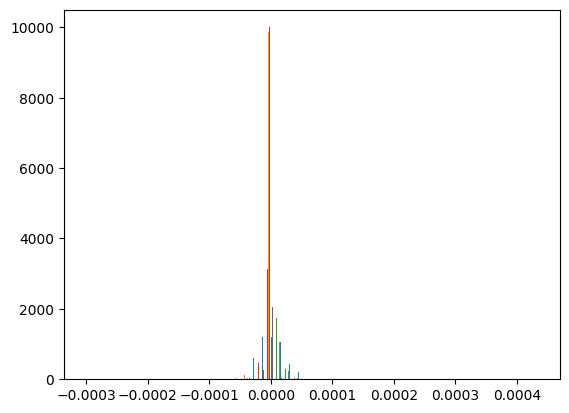

In [53]:
x = plt.hist(unscaled_pt.numpy() - reco_particles[:,:,0].numpy(), bins=100)

(array([103847.,  20953.,  19518.,  12656.,  13181.,   5135.,   3276.,
          1425.]),
 array([   0.,   25.,   50.,   75.,  100.,  150.,  200.,  300., 1000.]),
 <BarContainer object of 8 artists>)

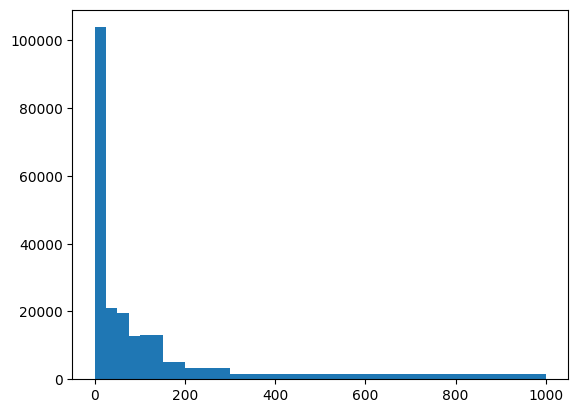

In [64]:
plt.hist(unscaled_pt.numpy().flatten(), bins=[0,25,50,75,100,150,200,300,1000])

In [69]:
print(unscaled_pt[0])

tensor([247.5000, 130.2500,  89.1250,  86.8750,  55.2813,  33.0312,  33.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,  44.1741,  93.1483])


In [71]:
mask_pt_greater_0 = unscaled_pt[:,:10] > 5 
mask_pt_lower_50 = unscaled_pt[:,:10] < 30

mask_pt_0_50 = torch.logical_and(mask_pt_grater_0, mask_pt_lower_50)
print(mask_pt_0_50)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


In [73]:
torch.max(unscaled_pt)

tensor(1403.0004)

In [72]:
print(flow_pr[mask_pt_0_50].shape)

torch.Size([0])


In [39]:
print(flow_pr)

tensor([[-36.4432,  -8.4614, -11.9981,  ...,   0.5705,   0.5705,   0.5705],
        [-13.8718, -23.8085,  -3.3919,  ...,   0.5705,   0.5705,   0.5705],
        [-40.0943, -20.8213,  -5.8146,  ...,   0.5705,   0.5705,   0.5705],
        ...,
        [ -6.1844, -15.3687, -24.3188,  ...,   0.5705,   0.5705,   0.5705],
        [-34.4876, -13.8191,  -6.4025,  ...,   0.5705,   0.5705,   0.5705],
        [-17.1896,  -0.2763, -30.9214,  ...,   0.5705,   0.5705,   0.5705]],
       grad_fn=<AddBackward0>)


# Loss

In [45]:
world_size = None

data = dataset_all.DatasetCombined(root, dtype=torch.float64, datasets=["partons_lab", "reco_lab"],
                                    reco_list_lab=['scaledLogRecoParticles', 'mask_lepton',
                                                'mask_jets','mask_met',
                                                'mask_boost', 'data_boost'],
                                    parton_list_lab=['logScaled_data_higgs_t_tbar_ISR'])

trainingLoader = DataLoader(
        data,
        batch_size= 32,
        shuffle=False if world_size is not None else True,
        sampler=DistributedSampler(train_dataset) if world_size is not None else None,

    )

optimizer = optim.Adam(list(tr_flow.parameters()) , lr=0.00001)

>>Loading datasets
Loading partons in LAB
PartonLevel LAB
Reading parton_level Files
Load logScaled_data_higgs_t_tbar_ISR
Parton: Move tensors to device (None) memory
Loading reco in LAB
RecoLevel LAB
Reading reco_level Files
Load scaledLogRecoParticles
Reco: Move tensors to device (None) memory
Loaded datasets:  ['partons_lab', 'reco_lab']


In [ ]:
path_to_conf = ''
model_weights = ''
with open(path_to_conf) as f:
        config = OmegaConf.load(path_to_conf)

if True:    
    
    log_mean_parton = data.partons_lab.mean_log_data_higgs_t_tbar_ISR
    log_std_parton = data.partons_lab.std_log_data_higgs_t_tbar_ISR
    log_mean_boost = data.partons_lab.mean_log_data_boost
    log_std_boost = data.partons_lab.std_log_data_boost
    mean_ps = data.partons_CM.mean_phasespace_intermediateParticles_onShell_logit
    scale_ps = data.partons_CM.std_phasespace_intermediateParticles_onShell_logit

    # Initialize model
    model = UnfoldingFlow(
                    pretrained_model=None,
                    load_conditioning_model=False,
                    scaling_partons_lab = [log_mean_parton, log_std_parton],
                    scaling_boost_lab = [log_mean_boost, log_std_boost],
                    scaling_partons_CM_ps = [mean_ps, scale_ps],

                    no_jets=config.input_shape.number_jets,
                    no_lept=config.input_shape.number_lept,
                    input_features=config.input_shape.input_features,
                    cond_hiddenFeatures=config.conditioning_transformer.hidden_features,
                    cond_dimFeedForward=config.conditioning_transformer.dim_feedforward_transformer,
                    cond_outFeatures=config.conditioning_transformer.out_features,
                    cond_nheadEncoder=config.conditioning_transformer.nhead_encoder,
                    cond_NoLayersEncoder=config.conditioning_transformer.no_layers_encoder,
                    cond_nheadDecoder=config.conditioning_transformer.nhead_decoder,
                    cond_NoLayersDecoder=config.conditioning_transformer.no_layers_decoder,
                    cond_NoDecoders=config.conditioning_transformer.no_decoders,
                    cond_aggregate=config.conditioning_transformer.aggregate,
                    cond_use_latent=config.conditioning_transformer.use_latent,
                    cond_out_features_latent=config.conditioning_transformer.out_features_latent,
                    cond_no_layers_decoder_latent=config.conditioning_transformer.no_layers_decoder_latent,   
        
                    flow_nfeatures=config.unfolding_flow.nfeatures,
                    flow_ncond=config.unfolding_flow.ncond, 
                    flow_ntransforms=config.unfolding_flow.ntransforms,
                    flow_hiddenMLP_NoLayers=config.unfolding_flow.hiddenMLP_NoLayers, 
                    flow_hiddenMLP_LayerDim=config.unfolding_flow.hiddenMLP_LayerDim,
                    flow_bins=config.unfolding_flow.bins,
                    flow_autoregressive=config.unfolding_flow.autoregressive,
                    flow_base=config.unfolding_flow.base,
                    flow_base_first_arg=config.unfolding_flow.base_first_arg,
                    flow_base_second_arg=config.unfolding_flow.base_second_arg,
                    flow_bound=config.unfolding_flow.bound,
                    randPerm=config.unfolding_flow.randPerm,
                    device=torch.device("cpu"),
                    dtype=torch.float64,
                    eps=config.training_params.eps)

    model.load_state_dict(torch.load(model_weights, map_location=torch.device("cpu"))["model_state_dict"])

    # Setting up DDP
    model = model.to(torch.device("cpu"))
    model.eval()

In [55]:
tr_flow = TransferFlow(no_recoVars=7, no_partonVars=3,
                 out_features_linearDNN=64,
                 
                 transformer_nhead=4,
                 transformer_num_encoder_layers=4,
                 transformer_num_decoder_layers=4,
                 transformer_dim_feedforward=64,
                 transformer_activation=nn.GELU(),
                 
                 flow_nfeatures=3,
                 flow_ncond=34, 
                 flow_ntransforms=5,
                 flow_hiddenMLP_NoLayers=16,
                 flow_hiddenMLP_LayerDim=128,
                 flow_bins=16,
                 flow_autoregressive=True,
                 flow_base='DiagNormal',
                 flow_base_first_arg=0,
                 flow_base_second_arg=0.3,
                 flow_bound=1.,
                 randPerm=False,
                 
                 device=torch.device('cpu'),
                 dtype=torch.float32,
                 eps=1e-4)

ii = 0
for e in range(10):
          
        N_train = 0
        N_valid = 0
            
        sum_loss = 0.
    
        # training loop    
        print("Before training loop")
        tr_flow.train()

        for i, data_batch in enumerate(trainingLoader):
            N_train += 1
            ii+=1

            optimizer.zero_grad()
            
            (logScaled_data_higgs_t_tbar_ISR,
             scaledLogRecoParticles, mask_lepton,
             mask_jets, mask_met,
             mask_boost, data_boost) = data_batch
            
            mask_recoParticles = torch.cat((mask_jets, mask_lepton, mask_met), dim=1)

            # remove prov
            if True:
                scaledLogRecoParticles = scaledLogRecoParticles[:,:,:-1]

            avg_flowPr, batch_flow_pr, flow_pr = tr_flow(scaledLogRecoParticles, logScaled_data_higgs_t_tbar_ISR,
                                                         data_boost, mask_recoParticles, mask_boost,
                                                         32, 10)
                    

            avg_flowPr.backward()
            optimizer.step()
            print(avg_flowPr.item())
            

Before training loop
-83.9643303985508
-102.6012157631452
-101.42285277269741
-108.31054313249706
-103.96656619890943
-103.59378531821196
-96.37625334310928
-106.23000139640905
-91.70372009474264
-92.2443125884378
-87.99381986408463
-100.92204492388557
-92.25718547468938
-97.2608279975494
-101.89203255683735
-93.43479184751993
-102.00784309151845
-101.07386803979583
-101.2330457123895
-83.99931513651171
-95.1283589498004
-82.1406976379478
-89.02669805160156
-107.4434084363919
-100.97298676694763
-92.12522791126152
-90.62383540629529
-102.51235729300683
-85.55894213153087
-101.31168416104993
-97.26396071372214
-98.66523504040597
-100.47264554641583
-104.21245099296019
-89.22807566120694
-92.64143616037029
-87.2705644119667
-112.57627197358906
-110.07537037154756
-86.70101794516208
-102.52339218172689
-77.83094293868473
-94.19359068204841
-89.04236757066963
-99.12886901950682
-95.23693030500418
-85.73071781711835
-91.37078379789206
-90.79807893334043
-96.24954718880326
-95.84560587455135

KeyboardInterrupt: 

# version from paper

In [6]:
import torch.nn as nn
import torch
import numpy as np
import utils
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
import zuko
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform
from zuko.distributions import DiagNormal
from memflow.unfolding_flow.utils import Compute_ParticlesTensor as particle_tools
import memflow.phasespace.utils as ps_utils

class TransferFlow_Paper(nn.Module):
    def __init__(self,
                 no_recoVars, no_partonVars,
                 
                 transformer_input_features=64,
                 transformer_nhead=8,
                 transformer_num_encoder_layers=4,
                 transformer_num_decoder_layers=4,
                 transformer_dim_feedforward=128,
                 transformer_activation=nn.GELU(),
                 
                 flow_nfeatures=12,
                 flow_ntransforms=5,
                 flow_hiddenMLP_NoLayers=4,
                 flow_hiddenMLP_LayerDim=128,
                 flow_bins=16,
                 flow_autoregressive=True,
                 flow_base=BoxUniform,
                 flow_base_first_arg=-1,
                 flow_base_second_arg=1,
                 flow_bound=1.,
                 randPerm=False,
                 no_max_objects=10,
                 
                 device=torch.device('cpu'),
                 dtype=torch.float32,
                 eps=1e-4):

        super(TransferFlow_Paper, self).__init__()
        
        self.device = device
        self.dtype = dtype
        self.eps = eps # used for small values like the mass of the gluon for numerical reasons
        
        self.linearDNN_reco = nn.Linear(in_features=no_recoVars, out_features=transformer_input_features)
        self.linearDNN_parton = nn.Linear(in_features=no_partonVars, out_features=transformer_input_features)
        self.linearDNN_boost = nn.Linear(in_features=4, out_features=transformer_input_features)
        self.gelu = nn.GELU()
        self.no_max_objects = no_max_objects
        
        self.transformer_model = nn.Transformer(d_model=transformer_input_features,
                                                nhead=transformer_nhead,
                                                num_encoder_layers=transformer_num_encoder_layers,
                                                num_decoder_layers=transformer_num_decoder_layers,
                                                dim_feedforward=transformer_dim_feedforward,
                                                activation=transformer_activation,
                                                batch_first=True)
        
        self.flow_pt = zuko.flows.NSF(features=flow_nfeatures,
                              context=transformer_input_features,
                              transforms=flow_ntransforms, 
                              bins=flow_bins, 
                              hidden_features=[flow_hiddenMLP_LayerDim]*flow_hiddenMLP_NoLayers, 
                              randperm=randPerm,
                              base=eval(flow_base),
                              base_args=[torch.ones(flow_nfeatures)*flow_base_first_arg, torch.ones(flow_nfeatures)*flow_base_second_arg],
                                   univariate_kwargs={"bound": flow_bound }, # Keeping the flow in the [-B,B] box.
                              passes= 2 if not flow_autoregressive else flow_nfeatures)

        self.flow_eta = zuko.flows.NSF(features=flow_nfeatures,
                              context=transformer_input_features + 1, # additional condition pt
                              transforms=flow_ntransforms, 
                              bins=flow_bins, 
                              hidden_features=[flow_hiddenMLP_LayerDim]*flow_hiddenMLP_NoLayers, 
                              randperm=randPerm,
                              base=eval(flow_base),
                              base_args=[torch.ones(flow_nfeatures)*flow_base_first_arg, torch.ones(flow_nfeatures)*flow_base_second_arg],
                                   univariate_kwargs={"bound": flow_bound }, # Keeping the flow in the [-B,B] box.
                              passes= 2 if not flow_autoregressive else flow_nfeatures)

        self.flow_phi = zuko.flows.NSF(features=flow_nfeatures,
                              context=transformer_input_features + 2, # additional condition pt/eta
                              transforms=flow_ntransforms, 
                              bins=flow_bins, 
                              hidden_features=[flow_hiddenMLP_LayerDim]*flow_hiddenMLP_NoLayers, 
                              randperm=randPerm,
                              base=eval(flow_base),
                              base_args=[torch.ones(flow_nfeatures)*flow_base_first_arg, torch.ones(flow_nfeatures)*flow_base_second_arg],
                                   univariate_kwargs={"bound": flow_bound }, # Keeping the flow in the [-B,B] box.
                              passes= 2 if not flow_autoregressive else flow_nfeatures)
        

    def disable_conditioner_regression_training(self):
        ''' Disable the conditioner regression training, but keep the
        latent space training'''
        self.cond_transformer.disable_regression_training()

    def enable_regression_training(self):
        self.cond_transformer.enable_regression_training()
        
    def forward(self,  scaling_reco_lab, scaling_partons_lab, scaling_RegressedBoost_lab,
                mask_reco, mask_boost, flow_eval="normalizing", Nsamples=0):
        
        scaledLogReco_afterLin = self.gelu(self.linearDNN_reco(scaling_reco_lab) * mask_reco[..., None])
        scaledLogParton_afterLin = self.gelu(self.linearDNN_parton(scaling_partons_lab))

        tgt_mask = self.transformer_model.generate_square_subsequent_mask(scaledLogReco_afterLin.size(1), device=self.device)
        # mask to keep the decoder autoregressive
        
        output_decoder = self.transformer_model(scaledLogParton_afterLin, scaledLogReco_afterLin,
                                                tgt_mask=tgt_mask)
        
        conditioning_pt = output_decoder[:,:self.no_max_objects]
        scaled_reco_lab_pt = scaling_reco_lab[:,:self.no_max_objects,0].unsqueeze(dim=2)
        flow_prob_pt = self.flow_pt(conditioning_pt).log_prob(scaled_reco_lab_pt)
        flow_prob_pt_batch = torch.sum(flow_prob_pt*mask_reco[:,:self.no_max_objects], dim=1) # take avg of masked objects
        avg_flow_prob_pt = flow_prob_pt_batch.mean()
        print(flow_prob_pt.shape)
        
        conditioning_eta = torch.cat((output_decoder[:,:self.no_max_objects], scaled_reco_lab_pt), dim=2) # add pt in conditioning
        scaled_reco_lab_eta = scaling_reco_lab[:,:self.no_max_objects,1].unsqueeze(dim=2)
        flow_prob_eta = self.flow_eta(conditioning_eta).log_prob(scaled_reco_lab_eta)
        flow_prob_eta_batch = torch.sum(flow_prob_eta*mask_reco[:,:self.no_max_objects], dim=1) # take avg of masked objects
        avg_flow_prob_eta = flow_prob_eta_batch.mean()
        print(flow_prob_eta.shape)
        
        conditioning_phi = torch.cat((output_decoder[:,:self.no_max_objects], scaled_reco_lab_pt, scaled_reco_lab_eta), dim=2)
        scaled_reco_lab_phi = scaling_reco_lab[:,:self.no_max_objects,2].unsqueeze(dim=2)
        flow_prob_phi = self.flow_phi(conditioning_phi).log_prob(scaled_reco_lab_phi)
        flow_prob_phi_batch = torch.sum(flow_prob_phi*mask_reco[:,:self.no_max_objects], dim=1) # take avg of masked objects
        avg_flow_prob_phi = flow_prob_phi_batch.mean()
        print(flow_prob_phi.shape)
                                
        return avg_flow_prob_pt, flow_prob_pt_batch, flow_prob_pt, \
                avg_flow_prob_eta, flow_prob_eta_batch, flow_prob_eta, \
                avg_flow_prob_phi, flow_prob_phi_batch, flow_prob_phi

In [7]:
tr_flow = None
#tr_flow.collect()
torch.cuda.empty_cache()
del tr_flow

tr_flow = TransferFlow_Paper(no_recoVars=7, no_partonVars=3,
                 transformer_input_features=32,
                 
                 transformer_nhead=2,
                 transformer_num_encoder_layers=1,
                 transformer_num_decoder_layers=1,
                 transformer_dim_feedforward=32,
                 transformer_activation=nn.GELU(),
                 
                 flow_nfeatures=1,
                 flow_ntransforms=5,
                 flow_hiddenMLP_NoLayers=16,
                 flow_hiddenMLP_LayerDim=128,
                 flow_bins=16,
                 flow_autoregressive=True,
                 flow_base='DiagNormal',
                 flow_base_first_arg=0,
                 flow_base_second_arg=0.3,
                 flow_bound=1.,
                 randPerm=False,
                 
                 device=device,
                 dtype=torch.float32,
                 eps=1e-4)

if device == torch.device('cuda'):
    print('move to cuda')
    tr_flow = tr_flow.cuda()

move to cuda


In [8]:
avg_flow_prob_pt, flow_prob_pt_batch, flow_prob_pt, \
avg_flow_prob_eta, flow_prob_eta_batch, flow_prob_eta, \
avg_flow_prob_phi, flow_prob_phi_batch, flow_prob_phi = tr_flow(scaledLogReco[:,:,:7], scaledLogParton, boostReco, maskedReco, maskBoost,
                                             10)

/home/user/micromamba/lib/python3.9/site-packages/zuko/transforms.py:425: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/BucketizationUtils.h:33.)
  return torch.searchsorted(seq, value[..., None]).squeeze(dim=-1)


torch.Size([1000, 10])
torch.Size([1000, 10])
torch.Size([1000, 10])
